### Setup, Connection

In [327]:
# database
from neo4j import GraphDatabase
import psycopg2

# data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# utility
import random
import getpass
import geocoder
from statistics import mode
from tqdm.notebook import tqdm

In [336]:
# connect to postgres
pg_password = getpass.getpass("Enter Postgres Password: ")
pg = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password=pg_password,
    host="localhost",
    port="5432"
)

Enter Postgres Password: ········


In [2]:
uri = "bolt://localhost:7666"
username = "neo4j"
password = "password"

def create_neo4j_session(uri, username, password):
    try:
        driver = GraphDatabase.driver(uri, auth=(username, password))
        session = driver.session()
        return session
    except Exception as e:
        print(f"Failed to create Neo4j session: {e}")
        return None

### Queries

#### (1) In what community(s) do accidents most densely occur in San Diego?

In [3]:
session = create_neo4j_session(uri, username, password)

# add full graph to GDS
project_full_graph = """
CALL gds.graph.project(
    'fullGraph',
    ['Accident'],
    {CLOSE_TO: {orientation: 'UNDIRECTED', type:'WITHIN_RANGE'}}
)
"""

result = session.run(project_full_graph)

session.close()

In [238]:
def get_community(locations, sample_prop=.05):
    result_locations = []
    for loc in locations:
        if not (random.randint(1, int(1/sample_prop)) - 1):  # randomly pick
            location = geocoder.osm(list(loc), method='reverse')
            if location.ok:
                address = location.raw['address']
                community = address.get('suburb') or address.get('neighbourhood') or address.get('city')
                if community:
                    result_locations.append(community)
    return mode(result_locations)

In [239]:
def dense_accident_communities(num_communities, gds_name='fullGraph', sample_prop=0.02):
    session = create_neo4j_session(uri, username, password)

    # find largest component in GDS
    community_detection = f"""
    CALL gds.beta.leiden.stream('{gds_name}')
    YIELD nodeId, communityId
    WITH communityId, count(*) AS communitySize, collect(gds.util.asNode(nodeId)) AS communityNodes
    ORDER BY communitySize DESC
    LIMIT {num_communities}

    UNWIND communityNodes AS n
    RETURN n.pt AS loc, communityId AS cId, communitySize AS cSize
    """

    result = session.run(community_detection)

    community_results = [(
        record['loc'].latitude, 
        record['loc'].longitude, 
        record['cId'],
        record['cSize']
    ) for record in result]
    session.close()
    
    # post processing
    comm_df = pd.DataFrame(community_results, columns=['lat', 'lng', 'cId', 'num_accidents'])
    communities = comm_df.groupby(['cId', 'num_accidents']).apply(lambda df: get_community(
        df[['lat', 'lng']].to_records(index=False), sample_prop=sample_prop
    ))
    
    return (
        communities
        .reset_index()
        .drop(columns=['cId'])
        .sort_values(by='num_accidents', ascending=False)
        .rename(columns={0: 'community'})
        .to_dict('records')
    )

In [240]:
dense_accident_communities(1, sample_prop=0.005)

[{'num_accidents': 695, 'community': 'City Heights'}]

In [241]:
dense_accident_communities(3, sample_prop=0.02)

[{'num_accidents': 695, 'community': 'City Heights'},
 {'num_accidents': 561, 'community': "Banker's Hill"},
 {'num_accidents': 500, 'community': 'Logan Heights'}]

#### (2) In what community(s) do accidents involving more injures ($>2$) most densely occur in San Diego?

In [256]:
def dense_more_injury_communities(num_communities, sample_prop=0.5):
    # find accident ids with more injuries
    cur = pg.cursor()
    query = """
    SELECT report_id
    FROM accidents
    WHERE injured > 2
    AND date_time >= '2022-01-01'
    """
    cur.execute(query)
    severe_ids = list(map(lambda tup: tup[0], cur.fetchall()))
    cur.close()
    
    # find severe accident and construct GDS graph
    session = create_neo4j_session(uri, username, password)

    severe_accidents_gds = f"""
    UNWIND {severe_ids} AS nId
    UNWIND {severe_ids} AS mId
    MATCH (n:Accident {{id: nId}})-[edges:WITHIN_RANGE]-(m:Accident {{id: mId}})
    WHERE id(n) > id(m)

    WITH DISTINCT edges AS r
    WITH startNode(r) AS startNode, endNode(r) AS endNode
    WITH gds.alpha.graph.project(
        'severeAccidents',
        startNode,
        endNode,
        {{}},
        {{}},
        {{undirectedRelationshipTypes: ['*']}}
    ) AS g
    RETURN g
    """
    
    result = session.run(severe_accidents_gds)
    session.close()
    
    # find communities
    communities = dense_accident_communities(num_communities, gds_name='severeAccidents', sample_prop=sample_prop)
    
    # drop gds graph
    try:
        session = create_neo4j_session(uri, username, password)
        drop_gds = "CALL gds.graph.drop('severeAccidents')"
        session.run(drop_gds)
    except:
        print('Dropping Graph Failed')
    finally:
        session.close()
    
    return communities

In [255]:
dense_more_injury_communities(5, sample_prop=0.5)

[{'num_accidents': 30, 'community': 'East Village'},
 {'num_accidents': 22, 'community': 'City Heights'},
 {'num_accidents': 21, 'community': 'Ocean Beach'},
 {'num_accidents': 21, 'community': 'North Park'},
 {'num_accidents': 20, 'community': 'Mid-City'}]

#### (3) For each month existed in the graph, where did accidents most frequently occur?

In [268]:
def monthly_dense_communities(sample_prop=0.2):
    # find accident ids with more injuries
    cur = pg.cursor()
    query = """
    SELECT to_char(date_time, 'YYYY-MM') AS year_month, ARRAY_AGG(report_id)
    FROM accidents
    WHERE date_time >= '2022-01-01'
    GROUP BY year_month
    """
    cur.execute(query)
    monthly_accidents = list(map(lambda tup: (tup[0], list(tup[1])), cur.fetchall()))
    cur.close()
    
    # process each month
    monthly_results = []
    for month, node_ids in monthly_accidents:
        session = create_neo4j_session(uri, username, password)
        create_gds = f"""
        UNWIND {node_ids} AS nId
        UNWIND {node_ids} AS mId
        MATCH (n:Accident {{id: nId}})-[edges:WITHIN_RANGE]-(m:Accident {{id: mId}})
        WHERE id(n) > id(m)

        WITH DISTINCT edges AS r
        WITH startNode(r) AS startNode, endNode(r) AS endNode
        WITH gds.alpha.graph.project(
            'monthlyAccidents',
            startNode,
            endNode,
            {{}},
            {{}},
            {{undirectedRelationshipTypes: ['*']}}
        ) AS g
        RETURN g
        """
        result = session.run(create_gds)
        result.consume()

        # find communities
        community = dense_accident_communities(1, gds_name='monthlyAccidents', sample_prop=sample_prop)[0]
        community['month'] = month
        monthly_results.append(community)

        # drop graph view
        drop_gds = "CALL gds.graph.drop('monthlyAccidents')"
        result = session.run(drop_gds)
        result.consume()
        session.close()

    return monthly_results

In [269]:
monthly_dense_communities(sample_prop=0.5)

Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
F

[{'num_accidents': 30, 'community': 'Sherman Heights', 'month': '2022-01'},
 {'num_accidents': 34, 'community': "Banker's Hill", 'month': '2022-02'},
 {'num_accidents': 33, 'community': 'City Heights', 'month': '2022-03'},
 {'num_accidents': 33, 'community': 'East Village', 'month': '2022-04'},
 {'num_accidents': 29, 'community': 'East Village', 'month': '2022-05'},
 {'num_accidents': 43, 'community': 'East Village', 'month': '2022-06'},
 {'num_accidents': 25, 'community': 'Mid-City', 'month': '2022-07'},
 {'num_accidents': 32, 'community': 'City Heights', 'month': '2022-08'},
 {'num_accidents': 30, 'community': 'East Village', 'month': '2022-09'},
 {'num_accidents': 35, 'community': "Banker's Hill", 'month': '2022-10'},
 {'num_accidents': 24, 'community': 'City Heights', 'month': '2022-11'},
 {'num_accidents': 21, 'community': "Banker's Hill", 'month': '2022-12'},
 {'num_accidents': 42, 'community': 'City Heights', 'month': '2023-01'},
 {'num_accidents': 19, 'community': 'City Heights

#### (4) For each 2-hour period in a day, where did accidents most frequently occur?

In [273]:
def hourly_dense_communities(period=2, sample_prop=0.2):
    # find accident ids with more injuries
    cur = pg.cursor()
    query = f"""
    SELECT
        to_char(date_time, 'HH24') :: INTEGER / {period} AS hour,
        ARRAY_AGG(report_id)
    FROM accidents
    WHERE date_time >= '2022-01-01'
    GROUP BY hour
    ORDER BY hour ASC
    """
    cur.execute(query)
    hourly_accidents = list(map(lambda tup: (tup[0], list(tup[1])), cur.fetchall()))
    cur.close()
    
    # process each hour group
    hourly_results = []
    for hour_group, node_ids in hourly_accidents:
        session = create_neo4j_session(uri, username, password)
        create_gds = f"""
        UNWIND {node_ids} AS nId
        UNWIND {node_ids} AS mId
        MATCH (n:Accident {{id: nId}})-[edges:WITHIN_RANGE]-(m:Accident {{id: mId}})
        WHERE id(n) > id(m)

        WITH DISTINCT edges AS r
        WITH startNode(r) AS startNode, endNode(r) AS endNode
        WITH gds.alpha.graph.project(
            'hourlyAccidents',
            startNode,
            endNode,
            {{}},
            {{}},
            {{undirectedRelationshipTypes: ['*']}}
        ) AS g
        RETURN g
        """
        result = session.run(create_gds)
        result.consume()

        # find communities
        community = dense_accident_communities(1, gds_name='hourlyAccidents', sample_prop=sample_prop)[0]
        start_hour = hour_group * period
        end_hour = (start_hour + period) % 24
        community['hours'] = f'{start_hour}:00-{end_hour}:00'
        hourly_results.append(community)

        # drop graph view
        drop_gds = "CALL gds.graph.drop('hourlyAccidents')"
        result = session.run(drop_gds)
        result.consume()
        session.close()

    return hourly_results

In [274]:
hourly_dense_communities(period=2, sample_prop=0.05)

Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
F

[{'num_accidents': 41, 'community': 'East Village', 'hours': '0:00-2:00'},
 {'num_accidents': 39, 'community': 'Sherman Heights', 'hours': '2:00-4:00'},
 {'num_accidents': 12, 'community': 'City Heights', 'hours': '4:00-6:00'},
 {'num_accidents': 23, 'community': 'San Diego', 'hours': '6:00-8:00'},
 {'num_accidents': 31, 'community': "Banker's Hill", 'hours': '8:00-10:00'},
 {'num_accidents': 39, 'community': 'Sherman Heights', 'hours': '10:00-12:00'},
 {'num_accidents': 58, 'community': "Banker's Hill", 'hours': '12:00-14:00'},
 {'num_accidents': 64, 'community': 'City Heights', 'hours': '14:00-16:00'},
 {'num_accidents': 71, 'community': 'City Heights', 'hours': '16:00-18:00'},
 {'num_accidents': 51, 'community': 'Golden Hill', 'hours': '18:00-20:00'},
 {'num_accidents': 69, 'community': 'City Heights', 'hours': '20:00-22:00'},
 {'num_accidents': 60, 'community': "Banker's Hill", 'hours': '22:00-0:00'}]

#### (5) Do accidents involving different vehicle types (i.e. Bird Scooters, BMW, etc.) tend to happen in specific places or distributed randomly?

Definition: Since we define an `WITHIN_RANGE` edge only when two `Accident` nodes happen less than 500 meters between each other, we determine how many total accidents on average happen around an accident involving a specific type of vehicle.

In [309]:
def vehicle_type_centrality(*vehicle_types):
    result = []
    for vehicle_type in vehicle_types:
        # find accidents with specific type
        cur = pg.cursor()
        query = f"""
        SELECT DISTINCT report_id
        FROM accident_info 
        WHERE veh_make = '{vehicle_type}'
        """
        cur.execute(query)
        veh_acc = list(map(lambda tup: tup[0], cur.fetchall()))
        cur.close()
        
        # find related accidents
        session = create_neo4j_session(uri, username, password)

        bird_graph = f"""
        UNWIND {veh_acc} AS aId
        MATCH (a:Accident {{id: aId}})-[r:WITHIN_RANGE]->(b)
        RETURN COUNT(b) AS num
        """

        graph_result = session.run(bird_graph)
        veh_result = [record['num'] for record in graph_result][0]
        session.close()
        
        result.append({
            'type': vehicle_type, 
            'total_accidents': len(veh_acc),
            'average_around': round(veh_result / len(veh_acc), 3) if len(veh_acc) > 0 else 0.0
        })
        
    return result

In [313]:
vehicle_type_centrality('TOYOTA', 'HONDA', 'BIRD', 'HARLEY-DAVIDSON', 'LIME')

Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))
Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))


[{'type': 'TOYOTA', 'total_accidents': 15088, 'average_around': 4.203},
 {'type': 'HONDA', 'total_accidents': 10322, 'average_around': 3.885},
 {'type': 'BIRD', 'total_accidents': 446, 'average_around': 2.256},
 {'type': 'HARLEY-DAVIDSON', 'total_accidents': 607, 'average_around': 4.168},
 {'type': 'LIME', 'total_accidents': 43, 'average_around': 7.535}]

#### (6) Do accidents tend to happen on roads that require more fixes?

In [323]:
# insert littlesis-org file
session = create_neo4j_session(uri, username, password)

report_accident = """
MATCH (a:Accident)-[:HAPPENS_ON]->(road:Road)
WITH road, count(a) AS numAccidents
MATCH (re:Report)-[:REPORTED_ON]->(road)
RETURN road, numAccidents, COUNT(*) AS numReports
"""
result = session.run(report_accident)
report_accident_count = [
    (record['numAccidents'], record['numReports'])
    for record in result
]

# Close the session and driver
session.close()

<AxesSubplot:title={'center':'Correlation between Numbers of Accidents and Reports'}, xlabel='numAccidents', ylabel='numReports'>

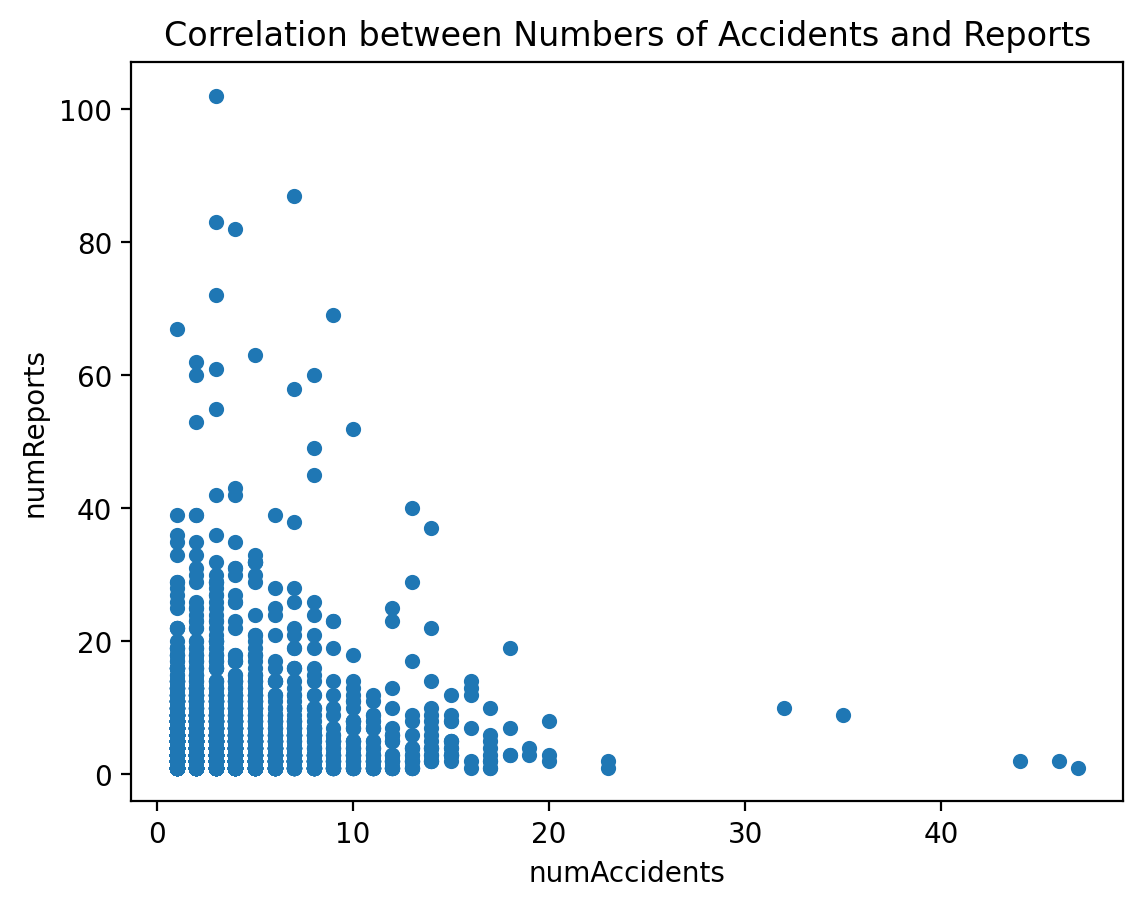

In [330]:
pd.DataFrame(report_accident_count, columns=['numAccidents', 'numReports']).plot(
    kind='scatter', 
    x='numAccidents', 
    y='numReports', 
    title='Correlation between Numbers of Accidents and Reports'
)

#### (7) For roads that have high accident numbers, what kinds of reports are most likely observed?

In [383]:
def frequent_report_types(top_n=10):
    # find top accident roads
    session = create_neo4j_session(uri, username, password)

    top_roads = f"""
    MATCH (a:Accident)-[:HAPPENS_ON]->(road:Road)
    WITH road, COUNT(a) AS numAccident
    MATCH (re:Report)-[:REPORTED_ON]->(road)
    WITH numAccident, COLLECT(re.id) AS reports
    ORDER BY numAccident DESC
    LIMIT {top_n}
    UNWIND reports AS one_report
    RETURN one_report
    """

    graph_result = session.run(top_roads)
    report_result = tuple(record['one_report'] for record in graph_result)
    session.close()
    
    # find report types
    cur = pg.cursor()
    query = f"""
    SELECT service_name, COUNT(*) AS num_services
    FROM reports 
    WHERE service_request_id IN {report_result}
    GROUP BY service_name
    ORDER BY num_services DESC
    """
    cur.execute(query)
    report_types = cur.fetchall()
    cur.close()
    
    return report_types

In [384]:
frequent_types = frequent_report_types(top_n=10)
frequent_types

[('Traffic Sign Maintenance', 24),
 ('Street Light Maintenance', 22),
 ('Graffiti - Code Enforcement', 12),
 ('Encampment', 9),
 ('ROW Maintenance', 9),
 ('Stormwater', 5),
 ('Pavement Maintenance', 5),
 ('Sidewalk Repair Issue', 4),
 ('Street Sweeping', 3),
 ('Tree Maintenance', 2),
 ('Illegal Dumping', 2),
 ('Traffic Engineering', 2),
 ('Parking', 2),
 ('Traffic Signal Timing', 1),
 ('Graffiti - Public', 1),
 ('Vegetation Encroachment', 1),
 ('Development Services - Code Enforcement', 1),
 ('Traffic Signal Issue', 1),
 ('Right-of-Way Code Enforcement', 1)]

Failed to write data to connection IPv4Address(('localhost', 7666)) (ResolvedIPv6Address(('::1', 7666, 0, 0)))


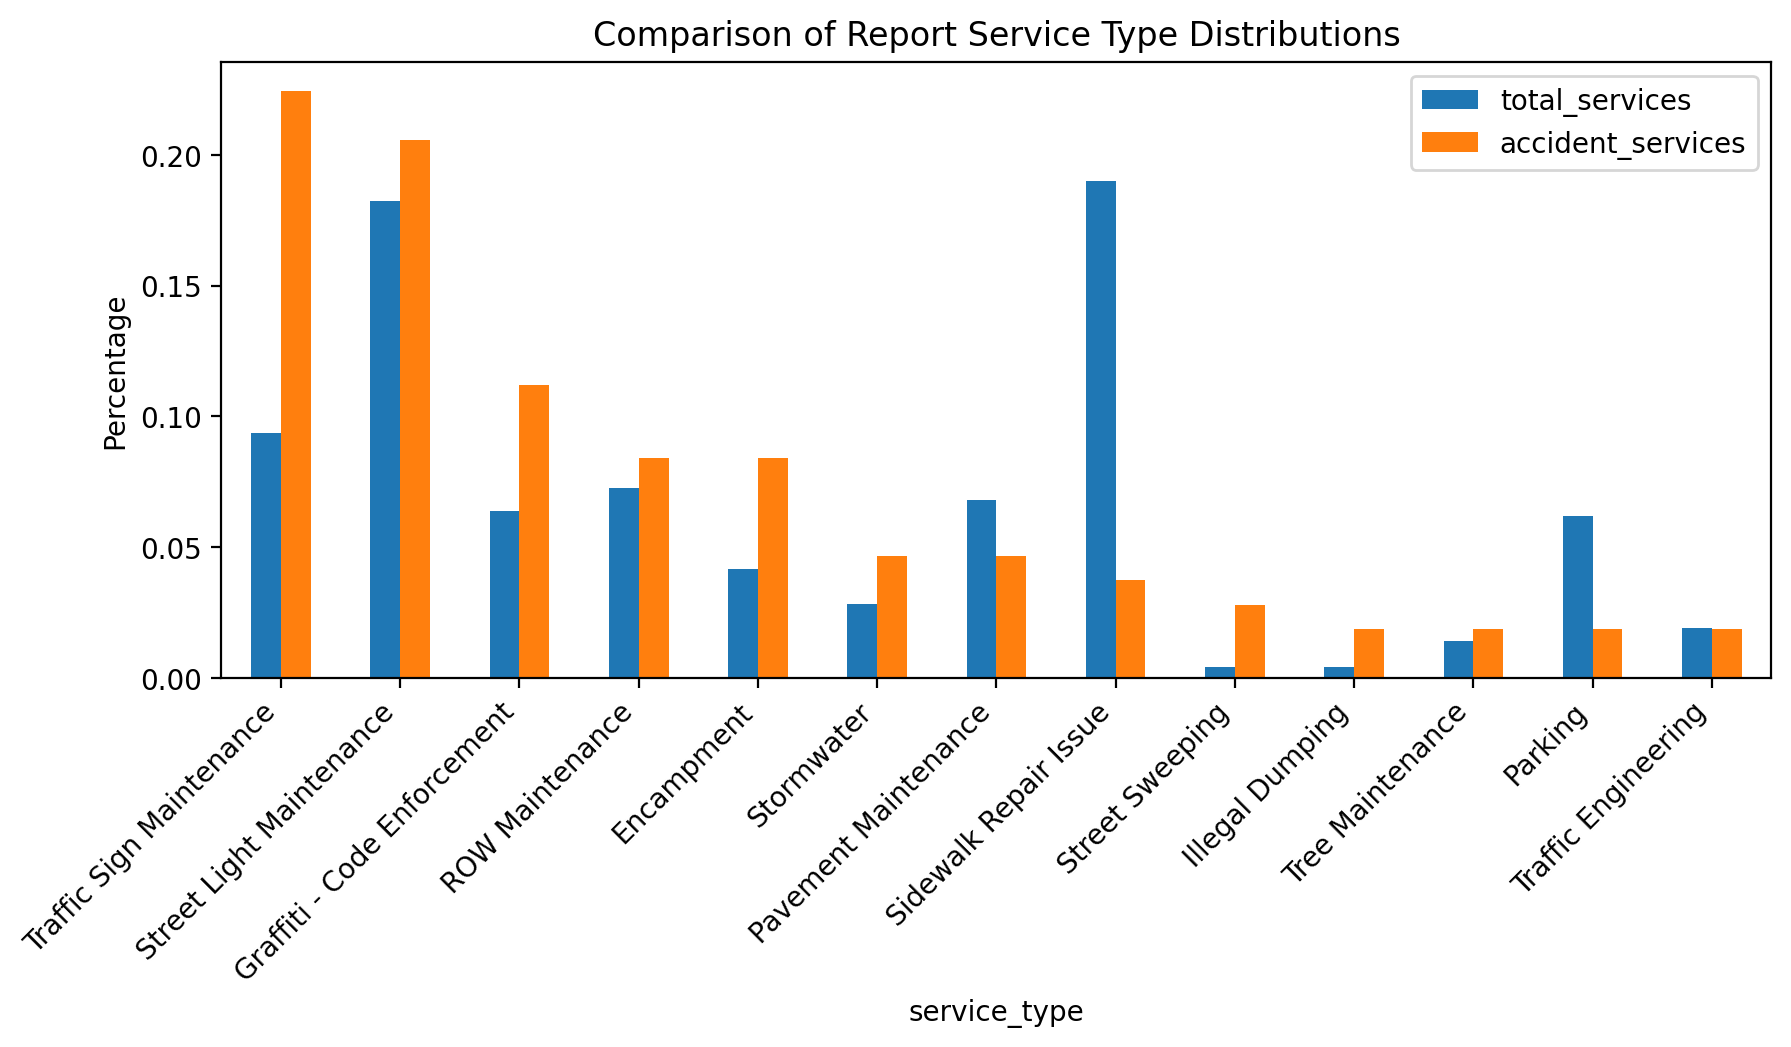

In [385]:
# compare to original distribution
cur = pg.cursor()
query = """
SELECT service_name, COUNT(*) AS num_services
FROM reports 
GROUP BY service_name
ORDER BY num_services DESC
"""
cur.execute(query)
all_report_types = cur.fetchall()
cur.close()

# normalize data 
report_distr = (
    pd.DataFrame(all_report_types, columns=['service_type', 'total_services'])
    .merge(pd.DataFrame(frequent_types), how='left', left_on='service_type', right_on=0)
    .fillna(0)
    .drop(columns=[0])
    .rename(columns={1: 'accident_services'})
    .sort_values(by='accident_services', ascending=False)
    .reset_index(drop=True)
)
report_distr['accident_services'] = (
    report_distr['accident_services'].astype(int) / 
    report_distr['accident_services'].sum()
)
report_distr['total_services'] = report_distr['total_services'] / report_distr['total_services'].sum()

# plot
report_distr[report_distr['accident_services'] > 0.01].set_index('service_type').plot(
    kind='bar', 
    rot=45,
    ylabel='Percentage',
    title='Comparison of Report Service Type Distributions',
    figsize=(10, 4)
)

x_ticks = plt.xticks(ha='right')

#### (8) What road features are most accidents associated with?

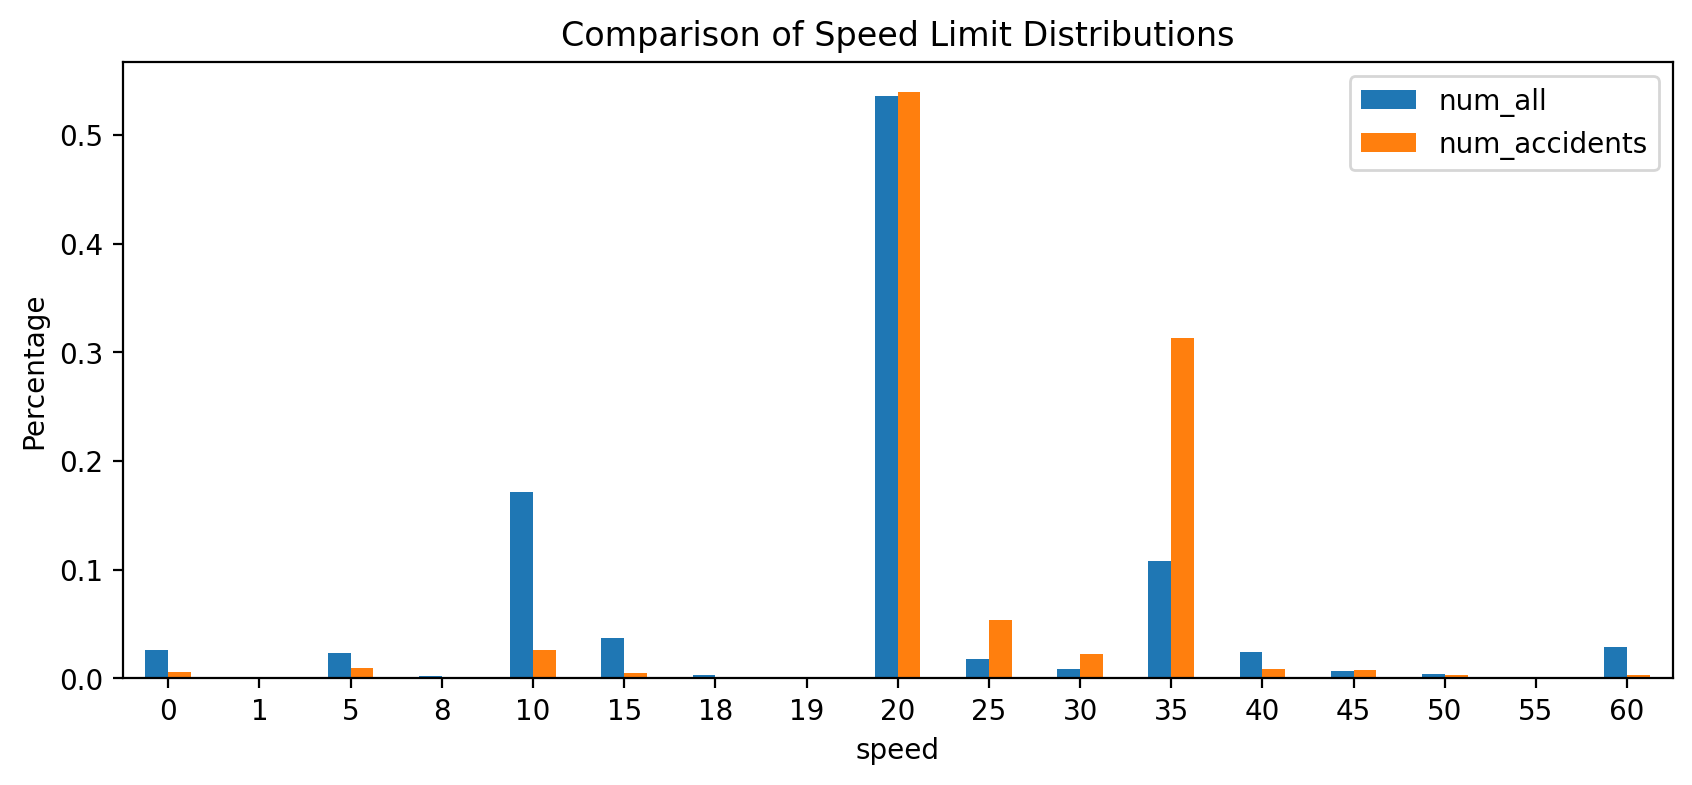

In [402]:
# find distributions
cur = pg.cursor()
query = """
SELECT r.speed, COUNT(acc)
FROM accidents AS acc
LEFT JOIN accidents_on_road AS aor
ON acc.report_id = aor.report_id
LEFT JOIN roads AS r
ON aor.objectid = r.objectid
WHERE r.speed IS NOT NULL
GROUP BY r.speed
ORDER BY r.speed ASC
"""
cur.execute(query)
accident_speeds = cur.fetchall()
cur.close()

cur = pg.cursor()
query = """
SELECT r.speed, COUNT(*)
FROM roads AS r
WHERE r.speed IS NOT NULL
GROUP BY r.speed
ORDER BY r.speed ASC
"""
cur.execute(query)
all_speeds = cur.fetchall()
cur.close()

# normalize data 
speed_distr = (
    pd.DataFrame(all_speeds, columns=['speed', 'num_all'])
    .merge(pd.DataFrame(accident_speeds), how='outer', left_on='speed', right_on=0)
    .fillna(0)
    .drop(columns=[0])
    .rename(columns={1: 'num_accidents'})
    .sort_values(by='speed')
    .reset_index(drop=True)
)
speed_distr['num_accidents'] = (
    speed_distr['num_accidents'].astype(int) / 
    speed_distr['num_accidents'].sum()
)
speed_distr['num_all'] = speed_distr['num_all'] / speed_distr['num_all'].sum()

# plot
title = speed_distr.set_index('speed').plot(
    kind='bar', 
    rot=0,
    ylabel='Percentage',
    title='Comparison of Speed Limit Distributions',
    figsize=(10, 4)
)

#### (9) Are one-way roads more likely to have accidents?

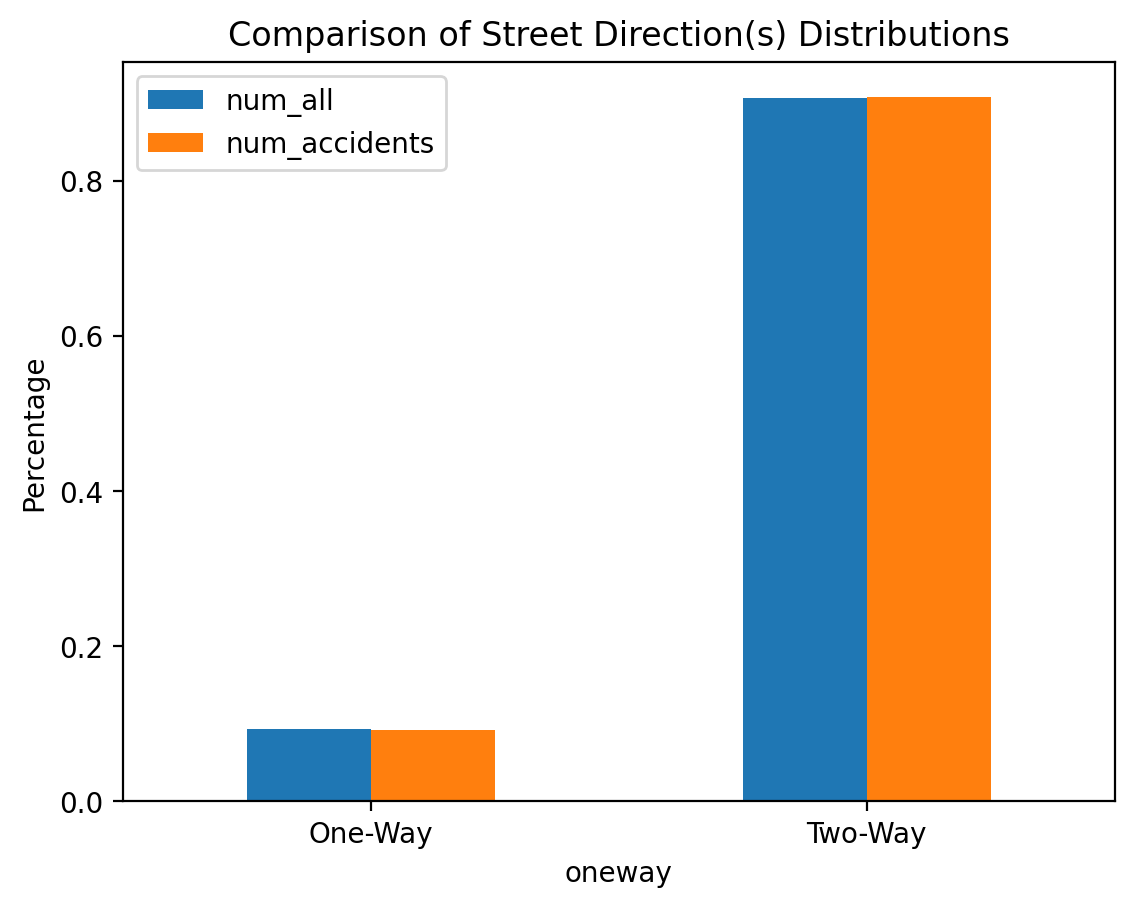

In [403]:
# find distributions
cur = pg.cursor()
query = """
SELECT 
    CASE WHEN r.oneway = 'B' THEN 'Two-Way' ELSE 'One-Way' END AS info,
    COUNT(acc)
FROM accidents AS acc
LEFT JOIN accidents_on_road AS aor
ON acc.report_id = aor.report_id
LEFT JOIN roads AS r
ON aor.objectid = r.objectid
WHERE r.oneway <> ''
GROUP BY info
"""
cur.execute(query)
accident_oneways = cur.fetchall()
cur.close()

cur = pg.cursor()
query = """
SELECT 
    CASE WHEN r.oneway = 'B' THEN 'Two-Way' ELSE 'One-Way' END AS info, 
    COUNT(*)
FROM roads AS r
WHERE r.oneway IS NOT NULL
GROUP BY info
"""
cur.execute(query)
all_oneways = cur.fetchall()
cur.close()

# normalize data 
oneway_distr = (
    pd.DataFrame(all_oneways, columns=['oneway', 'num_all'])
    .merge(pd.DataFrame(accident_oneways), how='outer', left_on='oneway', right_on=0)
    .fillna(0)
    .drop(columns=[0])
    .rename(columns={1: 'num_accidents'})
    .sort_values(by='oneway')
    .reset_index(drop=True)
)
oneway_distr['num_accidents'] = (
    oneway_distr['num_accidents'].astype(int) / 
    oneway_distr['num_accidents'].sum()
)
oneway_distr['num_all'] = oneway_distr['num_all'] / oneway_distr['num_all'].sum()

# plot
title = oneway_distr.set_index('oneway').plot(
    kind='bar', 
    rot=0,
    ylabel='Percentage',
    title='Comparison of Street Direction(s) Distributions'
)